# Similiarities with Periodic Data

At some point, I imagine, most data scientists (analysts, enthusiasts, -ists) will be given the problem of finding similar items in a dataset. Generally, when I hear similarity I immediately think of recommendation systems. However, I have recently been thinking of how to compare items that only have data sampled over time - that we assume has some periodicity. How can you compare periodic data? Obvously, some basic descriptive statistics are a good start, but what can do past that? This post will explore a (relatively) simple method to compare time sampled data.
<!-- TEASER_END --> 

First, you should be comfortable talking about similarity. If you are not, take a look through Jeff Phillips similarity [notes](http://www.cs.utah.edu/~jeffp/teaching/cs5140.html). We will talk similarity a bit more later, but in my opinion, good notes/references are never a bad thing. 

A quick Google search with provide you many ways to compare time series data. However, I wasn't totally satisfied with the results that I saw and was motivated to write this post.

### Warning: Business Motivation 

I know, we are talking about data science, but someone typically pays us to do this stuff. So we should discuss, at least a little, the uses/implications of something like this for your boss. It'll be quick.

Businesses that have locations throughout the world, typically, have a motivation to know how demand for their product(s) change overtime. In addition, they may also want to know which locations have similar demand patterns - this can help production rates, or for data science, give us other tools to model places. If you knew that demand patterns in two different locations are extremely similar, you could potentially increase the size of your dataset by combining them.

In this notebook, we will present a method for finding similar regions with only the time series data. We will do this with the pollution data set available on [Kaggle](https://www.kaggle.com/sogun3/uspollution).

# Pollution Data

You can find the data [here](https://www.kaggle.com/sogun3/uspollution).

This data set was collected by the EPA, and gives levels of specific pollutants in different U.S. cities from the year 2000 - 2016. There is a considerable amount of missing data, especially in the early years. For the purpose of this post we will fill missing data with 0s as better data imputation methods are not in the scope of this post.

In [ ]:
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

%matplotlib inline
plt.rcParams.update({"figure.figsize": (12,6), "font.size": 16})

In [2]:
data = pd.read_csv('data/pollution_us_2000_2016.csv')

In [3]:
data = data.fillna(0)
data['date'] = pd.to_datetime(data['Date Local'])

# Time Series Matrix

For this analysis we need to build a 'time series matrix'. This is effectively just stacking the time series vectors on top of each other to create the matrix. In this represenatation each row is a location and each column is a day. The value at each $i, j$ is the value for a given pollutant.

Below we have written a simple function to create a time series matrix. We will group by location column and pick a parameter to put as the daily value.

In [4]:
def build_timeseries_matrix(data, group_col='Site Num', parameter='NO2 Mean', date_min=None,):
    """
    Build a time series matrix from the pollution data.
    
    Parameters
    ----------
    data: pd.DataFrame
    group_col: string, default 'Site Num' (column name of df)
    parameter: string, default 'NO2 Mean' (column name of df)
    
    Returns
    -------
    time_df: pd.DataFrame
    """
    group = data.groupby(group_col)
    groups = np.unique(data[group_col])
    
    if date_min is None:
        date_min = np.min(data['date'])
    date_max = np.max(data['date'])

    dates = pd.date_range(start=date_min.strftime('%Y-%m-%d'), end=date_max.strftime('%Y-%m-%d'))
    time_matrix = np.zeros((len(groups), len(dates)))
    time_df = pd.DataFrame(time_matrix, index=groups, columns=dates)
    
    for grp in groups:
        g = group.get_group(grp)
        msk = g['date'] > date_min
        time_df.loc[grp, g[msk]['date'].values] = g[msk][parameter].values
    
    return time_df

In [5]:
ts_sitenum = build_timeseries_matrix(
    data,
    group_col='Site Num',
    parameter='NO2 Mean',
    date_min=datetime.datetime(2015, 1, 1)
)

We now have a nice time series matrix. We have only included the dates from 2014 forward to ensure that we have more complete data - there seems to be more missing data as you move back in time and for this post we only want to compare the periods over a year or so.

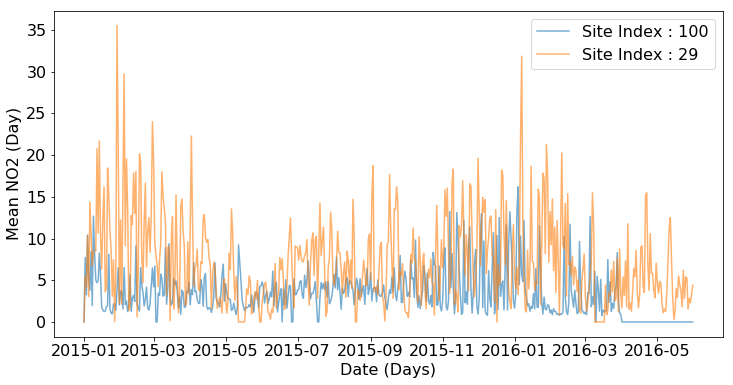

In [16]:
fig = plt.figure('Inidvidual Sites')
ax = fig.add_subplot(111)
ax.plot(
    ts_sitenum.columns,
    ts_sitenum.iloc[50],
    label='Site Index : {}'.format(ts_sitenum.iloc[50].name),
    alpha=0.6
)
ax.plot(
    ts_sitenum.columns,
    ts_sitenum.iloc[25],
    label='Site Index : {}'.format(ts_sitenum.iloc[25].name),
    alpha=0.6
)
ax.legend(loc='best')
ax.set_xlabel('Date (Days)')
ax.set_ylabel('Mean NO2 (Day)')
plt.show()

In the plot below we are showing the entire 'time series matrix'. As noted above, each row represents a Site Number, each column represents a day (in order from 2014 on the left to 2016 on the right), and each pixel is the mean NO2 for that day and site. This is the matrix we will be working with to determine the similarity of sites.

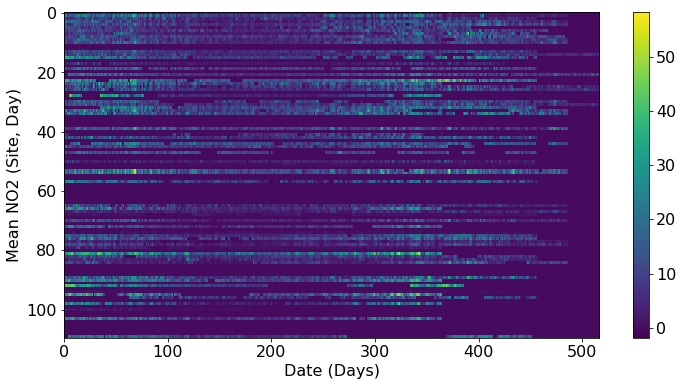

In [17]:
fig = plt.figure('All Sites')
ax = fig.add_subplot(111)
im = ax.imshow(ts_sitenum.values, aspect='auto')
ax.set_xlabel('Date (Days)')
ax.set_ylabel('Mean NO2 (Site, Day)')
plt.colorbar(im)
plt.show()

# Similarity

Now for the fun stuff. How do we determine if the similarity of two time series? Well, there are a number of similarity metrics that we could employ (jaccard similarity, cosine similarity, ...). If you are not familiar with those got take a quick read through these [notes](http://www.cs.utah.edu/~jeffp/teaching/cs5140/L3-Jaccard+nGram.pdf), you won't regret it. While you're there you should book mark this [page](http://www.cs.utah.edu/~jeffp/teaching/cs5140.html) I'm sure you'll find other topics of interest.

So why do we not want to use either the jaccard or cosine similarity. Well, with periodicity, you can have similar patterns that are shifted from each other. Those similarity metrics will not capture that, so we need a tool that can take into account the shift of the data as well.

Working in astronomy for a few years, one of my favorite tools became cross correlation - one of the main methods used to determine the speed of a star from spectra. Cross correlation essentially allows you to slide one series across another and see where the match up the best. Computatationally that does not sound easy. Luckily for us, there are some super cool transforms that make this a relatively simple task. We will transform the time series data (signal) into Fourier space. From there, cross correlation is just the multiplication of 2 signals. Well its a bit more complicated, you need the complex conjugate of one of the signals. (Whew! thats just calling x.conj() in numpy.)

Below we will write a function to return the similarity matrix for time series data. We will first take the Fourier transform of every row (location) and the user mulitplication in the Fourier space to cross correlate the signal with every other signal. We are going to get kind of trick with numpy, so please feel free to disect and mess with this function.

For some nice visualizations and details on cross correlation see the [Wikipedia](https://en.wikipedia.org/wiki/Cross-correlation) page.

In [18]:
def ts_sim(X):
    whitened = X - np.mean(X, axis=1).reshape(-1, 1)
    whitened = whitened / (np.sqrt(np.sum(whitened**2, axis=1)).reshape(-1, 1) + 1e-4)
    fft = np.fft.fft(whitened, axis=1, norm='ortho')
    sim = np.abs(np.dot(fft, fft.T.conj()))
    return sim

That's it, that is the entire function. We whiten the data, (think z-score) and then use cross correlation to find similar places. Below you will see the similarity matrix. The diagnol, ideally, should be all 1 (yellow). However, if you noticed above there is a considerable amount of missing data - so in some cases you will not see a value at all.

In [19]:
sim = ts_sim(ts_sitenum.values)

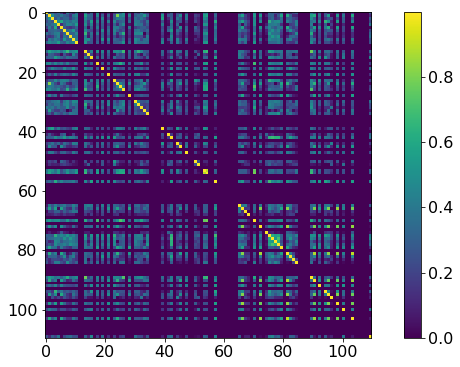

In [20]:
plt.imshow(sim)
plt.colorbar()

## Results

Ok, so how did we do? What places look similar and what places don't. Let's look at the top 5 similar site numbers (locations) to a given row - let's try index 4. We expect that the most similar place, with respect to pollution pattern, to index 4 (or Calexico, California) would be Calexico, California - and we got that answer, good job us. Anyway, we also want to look at the next 5 or so similar places. Below you will see the plots overlaid on each other - it actually does a pretty good job, the places that it found definitely have similar seasonal trends.

[ 4 10 53 54 13]
California, Calexico


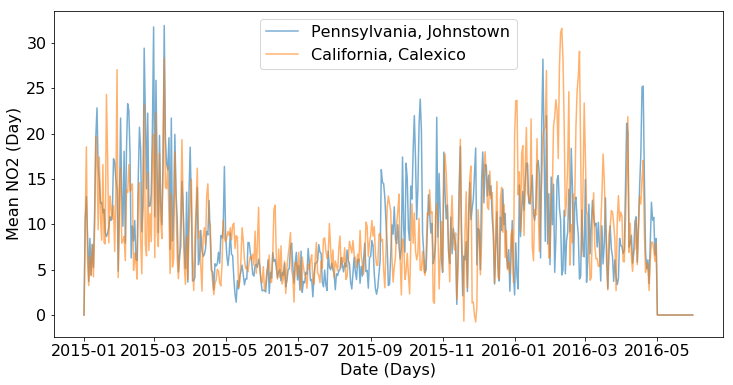

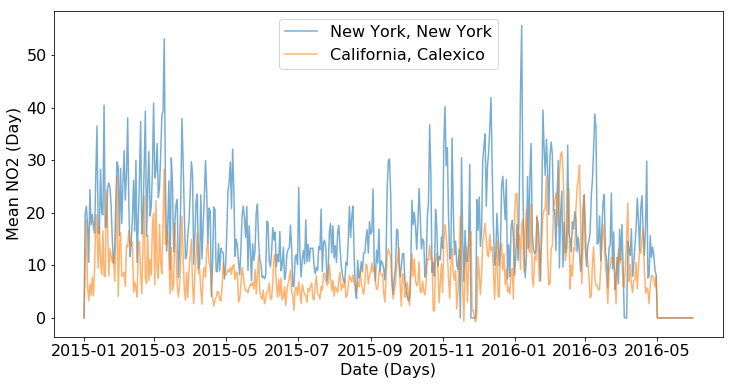

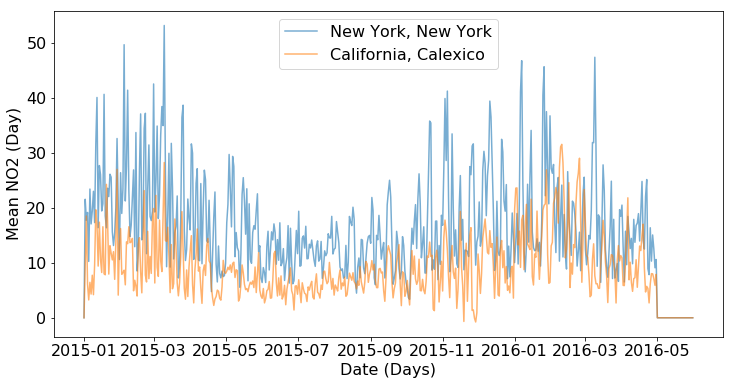

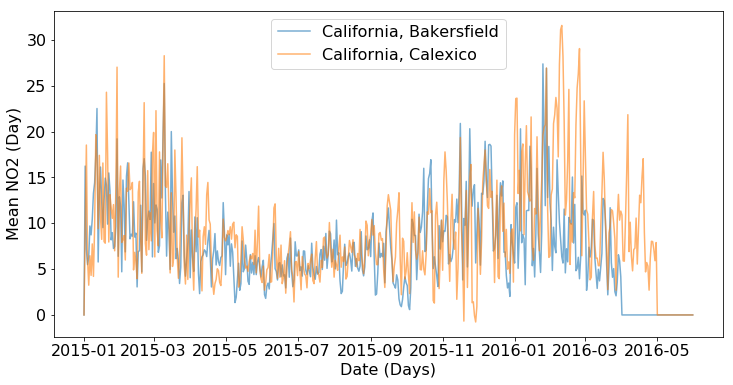

In [43]:
sim_idx = 4

top_n = 5
top_n_idx = np.argsort(sim[sim_idx])[::-1][:top_n]
print(top_n_idx)
site_num_idx = ts_sitenum.iloc[top_n_idx].index
site_num_idx_lst = list(site_num_idx)

site_num_grp = data.groupby('Site Num')
target_idx = site_num_idx_lst[0]
target = site_num_grp.get_group(target_idx)
target_state_city = "{}, {}".format(target.iloc[0]['State'], target.iloc[0]['City'])
print(target_state_city)

for idx in site_num_idx_lst[1:]:
    site = site_num_grp.get_group(idx)
    state = site.iloc[0]['State']
    city = site.iloc[0]['City']
    compare_state_city = "{}, {}".format(state, city)

    fig = plt.figure('Inidvidual Sites')
    ax = fig.add_subplot(111)
    site_idx = 'Site Index : {}'.format(ts_sitenum.loc[idx].name)
    ax.plot(
        ts_sitenum.columns,
        ts_sitenum.loc[idx],
        label=compare_state_city,
        alpha=0.6
    )
    target_site_idx = 'Site Index : {}'.format(ts_sitenum.loc[target_idx].name)
    ax.plot(
        ts_sitenum.columns,
        ts_sitenum.loc[target_idx],
        label=target_state_city,
        alpha=0.6
    )
    ax.legend(loc='best')
    ax.set_xlabel('Date (Days)')
    ax.set_ylabel('Mean NO2 (Day)')
    plt.show()
    